# Example 2: Analysis of groundwater monitoring networks using Pastas

This notebook is supplementary material to the following paper submitted to Groundwater:

*Collenteur, R.A., Bakker, M., Caljé, R., Klop, S.A., Schaars, F. (2019) [Pastas: open source software for the analysis of groundwater time series](https://ngwa.onlinelibrary.wiley.com/doi/abs/10.1111/gwat.12925). Groundwater. doi: 10.1111/gwat.12925.*

In this second example, it is demonstrated how scripts can be used to analyze a large number of time series. Consider a pumping well field surrounded by a number of observations wells. The pumping wells are screened in the middle aquifer of a three-aquifer system. The objective is to estimate the drawdown caused by the groundwater pumping in each observation well.


## 1. Import the packages

In [1]:
# Import the packages
import pandas as pd
import pastas as ps
import numpy as np
import os

import matplotlib.pyplot as plt

ps.show_versions()
ps.set_log_level("ERROR")

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.19.2
Scipy version: 1.6.0
Pandas version: 1.2.1
Pastas version: 0.17.0b
Matplotlib version: 3.3.2


## 2. Importing the time series
In this codeblock the time series are imported. The following time series are imported:

- 44 time series with head observations [m] from the monitoring network;
- precipitation [m/d] from KNMI station Oudenbosch;
- potential evaporation [m/d] from KNMI station de Bilt;
- Total pumping rate [m3/d] from well field Seppe.

In [2]:
# Dictionary to hold all heads
heads = {}

# Load a metadata-file with xy-coordinates from the groundwater heads
metadata_heads = pd.read_csv("data/metadata_heads.csv", index_col=0)
distances = pd.read_csv("data/distances.csv", index_col=0)

# Add the groundwater head observations to the database
for fname in os.listdir("./data/heads/"):
    fname = os.path.join("./data/heads/", fname)
    obs = pd.read_csv(fname, parse_dates=True, index_col=0, squeeze=True)
    heads[obs.name] = obs

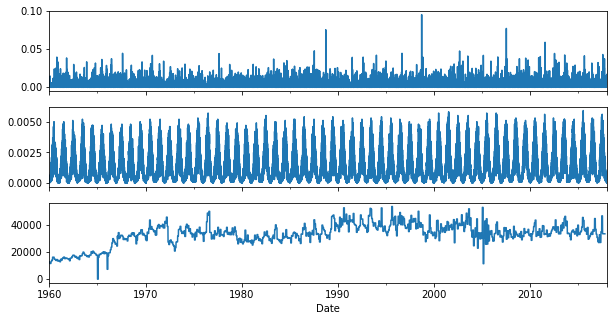

In [3]:
# Load a metadata-file with xy-coordinates from the explanatory variables
metadata = pd.read_csv("data/metadata_stresses.csv", index_col=0)

# Import the precipitation, evaporation and well time series
rain = pd.read_csv("data/rain.csv", parse_dates=True, index_col=0, squeeze=True)
evap = pd.read_csv("data/evap.csv", parse_dates=True, index_col=0, squeeze=True)
well = pd.read_csv("data/well.csv", parse_dates=True, index_col=0, squeeze=True)

# Plot the stresses
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10,5), sharex=True)
rain.plot(ax=ax1)
evap.plot(ax=ax2)
well.plot(ax=ax3)
plt.xlim("1960", "2018");

## 3/4/5. Creating and optimizing the Time Series Model

For each time series of groundwater head observations a TFN model is constructed with the following model components:
- A Constant
- A NoiseModel
- A RechargeModel object to simulate the effect of recharge
- A StressModel object to simulate the effect of groundwater extraction


***Calibrating all models can take a couple of minutes!!***

In [4]:
# Create folder to save the model figures
mls = {}
mlpath = "models"
if not os.path.exists(mlpath):
    os.mkdir(mlpath)

# Choose the calibration period
tmin = "1970"
tmax = "2017-09"
num = 0

for name, head in heads.items():
    # Create a Model for each time series and add a StressModel2 for the recharge
    ml = ps.Model(head, name=name)

    # Add the RechargeModel to simulate the effect of rainfall and evaporation
    rm = ps.RechargeModel(rain, evap, rfunc=ps.Gamma, name="recharge")
    ml.add_stressmodel(rm)
    
    # Add a StressModel to simulate the effect of the groundwater extractions
    sm = ps.StressModel(well / 1e6, rfunc=ps.Hantush, name="well", settings="well", up=False)
    ml.add_stressmodel(sm)
    
    # Estimate the model parameters
    ml.solve(tmin=tmin, tmax=tmax, report=False, solver=ps.LmfitSolve)

    # Check if the estimated effect of the groundwater extraction is significant.
    # If not, delete the stressmodel and calibrate the model again.
    gain, stderr = ml.parameters.loc["well_A", ["optimal", "stderr"]]
    if stderr is None:
        stderr = 10
    if 1.96 * stderr > -gain:
        num += 1
        ml.del_stressmodel("well")
        ml.solve(tmin=tmin, tmax=tmax, report=False)
    
    # Plot the results and store the plot
    mls[name] = ml
    ml.plots.results()
    path = os.path.join(mlpath, name + ".png")
    plt.savefig(path, bbox_inches="tight")
    plt.close()
    
print(f"The number of models where the well is dropped from the model is {num}")

The number of models where the well is dropped from the model is 6


# Make plots for publication
In the next codeblocks the Figures used in the Pastas paper are created. The following figures are created:

- Figure of the drawdown estimated for each observations well; 
- Figure of the decomposition of the different contributions;
- Figure of the pumping rate of the well field.

### Figure of the drawdown estimated for each observations well

In [5]:
try:
    from timml import ModelMaq, Well
    plot_timml = True
    # Values from REGIS II v2.2 (Site id B49F0240)
    z = [9, -25, -83, -115, -190] # Reference to NAP
    kv = np.array([1e-3, 5e-3]) # Min-Max of Vertical hydraulic conductivity for both leaky layer
    D1 = z[0]-z[1] # Estimated thickness of leaky layer
    c1 = D1/kv # Estimated resistance
    D2 = z[2] - z[3]
    c2 = D2 / kv

    kh1 = np.array([1e0, 2.5e0]) # Min-Max of Horizontal hydraulic conductivity for aquifer 1
    kh2 = np.array([1e1, 2.5e1]) # Min-Max of Horizontal hydraulic conductivity for aquifer 2

    mlm = ModelMaq(kaq=[kh1.mean(), 35], z=z, c=[c1.max(), c2.mean()], \
                  topboundary='semi', hstar=0)
    w = Well(mlm, 0, 0, 34791, layers=1)
    mlm.solve()
    x = np.linspace(100, 5000, 100)
    h = mlm.headalongline(x, 0)
except:
    plot_timml = False

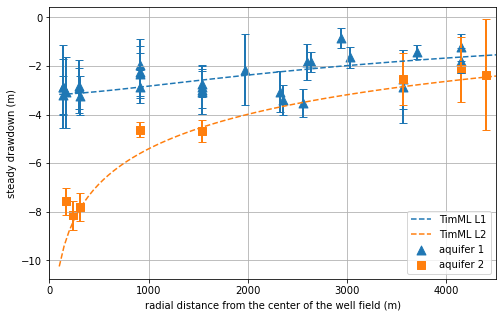

In [7]:
# Get the parameters and distances to plot
params = pd.DataFrame(index=mls.keys(), columns=["optimal", "stderr"], dtype=float)
for name, ml in mls.items():
    if "well" in ml.stressmodels.keys():
        params.loc[name] = ml.parameters.loc["well_A", ["optimal", "stderr"]] * well.loc["2007":].mean() /1e6

# Select model per aquifer
shallow = metadata_heads.z.loc[(metadata_heads.z<96)].index
aquifer = metadata_heads.z.loc[(metadata_heads.z<186) & (metadata_heads.z>96)].index

# Make the plot
fig = plt.figure(figsize=(8,5))
plt.grid(zorder=-10)

display_error_bars = True

if display_error_bars:
    plt.errorbar(distances.loc[shallow, "Seppe"], params.loc[shallow, "optimal"], 
                 yerr=1.96*params.loc[shallow, "stderr"], linestyle="", 
                 elinewidth=2, marker="", markersize=10, capsize=4)
    plt.errorbar(distances.loc[aquifer, "Seppe"], params.loc[aquifer, "optimal"], 
                 yerr=1.96*params.loc[aquifer, "stderr"], linestyle="", 
                 elinewidth=2, marker="", capsize=4)   

plt.scatter(distances.loc[shallow], params.loc[shallow, "optimal"], marker="^", s=80)
plt.scatter(distances.loc[aquifer], params.loc[aquifer, "optimal"], marker="s", s=80)

# Plot two-layer TimML model for comparison
if plot_timml:
    plt.plot(x, h[0], color="C0", linestyle="--" )
    plt.plot(x, h[1], color="C1", linestyle="--" )
    legend = ["TimML L1", "TimML L2", "aquifer 1", "aquifer 2"]
else:
    legend = ["aquifer 1", "aquifer 2"]

plt.ylabel("steady drawdown (m)")
plt.xlabel("radial distance from the center of the well field (m)")
plt.xlim(0, 4501)
plt.legend(legend, loc=4)

### Example figure of a TFN model 

Text(0.5, 1.0, 'pumping well')

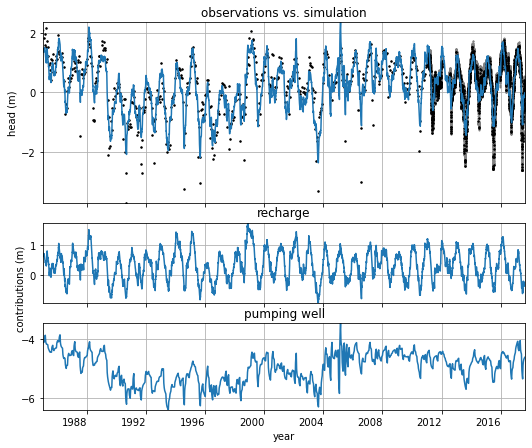

In [8]:
# Select a model to plot
ml = mls["B49F0232_5"]

# Create the figure
[ax1, ax2, ax3] = ml.plots.decomposition(split=False, figsize=(7,6), ytick_base=1, tmin="1985")
plt.xticks(rotation=0)
ax1.set_yticks([2, 0, -2])
ax1.set_ylabel("head (m)")
ax1.legend().set_visible(False)
ax3.set_yticks([-4, -6])
ax2.set_ylabel("contributions (m)                ") # Little trick to get the label right
ax3.set_xlabel("year")
ax3.set_title("pumping well")

### Figure of the pumping rate of the well field

(-6940.0, 17532.0)

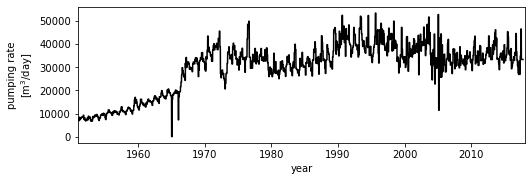

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,2.5), sharex=True)
ax.plot(well, color="k")
ax.set_ylabel("pumping rate\n[m$^3$/day]")
ax.set_xlabel("year")
ax.set_xlim(pd.Timestamp("1951"), pd.Timestamp("2018"))